In [1]:
import json
import random
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import librosa
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras

1.LOAD DATA

In [3]:
DATA_PATH = "data_10.json"

In [4]:
def load_data(data_path):
    with open(data_path,"r") as f:
        data = json.load(f)
    #convert lists to numpy array
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    print("Data succesfully loaded!")
    
    return X,y

In [5]:
X,y = load_data(DATA_PATH)

Data succesfully loaded!


In [6]:
X.shape

(9986, 130, 13)

In [7]:
y.shape

(9986,)

In [8]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [9]:
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

# add an axis to input sets
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [10]:
X_train.shape

(5991, 130, 13, 1)

In [11]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [12]:
# build the CNN
model_cnn = keras.Sequential()

# 1st conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

# output layer
model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [13]:
# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                        

In [15]:
# train model
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

Epoch 1/50
188/188 [==============================] - 8s 31ms/step - loss: 2.5269 - accuracy: 0.2100 - val_loss: 1.9298 - val_accuracy: 0.3391
Epoch 2/50
188/188 [==============================] - 6s 30ms/step - loss: 1.9582 - accuracy: 0.3365 - val_loss: 1.6581 - val_accuracy: 0.4112
Epoch 3/50
188/188 [==============================] - 6s 33ms/step - loss: 1.7376 - accuracy: 0.3953 - val_loss: 1.5231 - val_accuracy: 0.4579
Epoch 4/50
188/188 [==============================] - 6s 32ms/step - loss: 1.6042 - accuracy: 0.4380 - val_loss: 1.4266 - val_accuracy: 0.4840
Epoch 5/50
188/188 [==============================] - 6s 32ms/step - loss: 1.4806 - accuracy: 0.4680 - val_loss: 1.3582 - val_accuracy: 0.5187
Epoch 6/50
188/188 [==============================] - 6s 30ms/step - loss: 1.4134 - accuracy: 0.4972 - val_loss: 1.2743 - val_accuracy: 0.5494
Epoch 7/50
188/188 [==============================] - 6s 33ms/step - loss: 1.3494 - accuracy: 0.5129 - val_loss: 1.2342 - val_accuracy: 0.5561

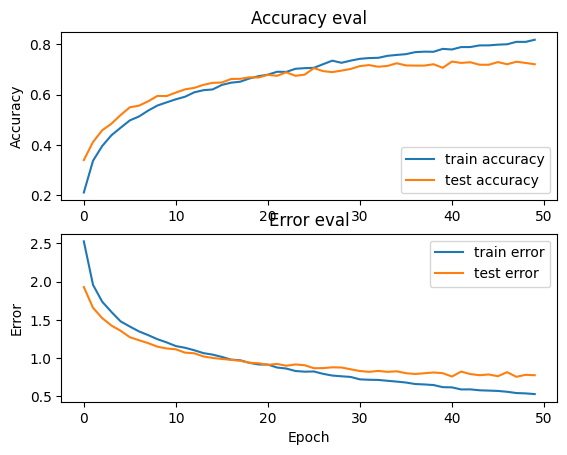

In [16]:
# plot accuracy and error as a function of the epochs
plot_history(history)

In [17]:
model_cnn.save("MGR_model.h5")

PREDICTION TEST SET

In [18]:
# pick a sample to predict from the test set
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [19]:
X_to_predict.shape

(130, 13, 1)

In [20]:
print("Real Genre:", y_to_predict)

Real Genre: 0


In [21]:
# add a dimension to input data for sample - model.predict() expects a 4d array in this case
X_to_predict = X_to_predict[np.newaxis, ...] # array shape (1, 130, 13, 1)

In [22]:
X_to_predict.shape

(1, 130, 13, 1)

In [23]:
# perform prediction
prediction = model_cnn.predict(X_to_predict)

1/1 [==============================] - 0s 111ms/step


In [24]:
# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Predicted Genre: 5


In [25]:
# pick a sample to predict from the test set
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]

prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 6
1/1 [==============================] - 0s 22ms/step
Predicted Genre: 6


In [26]:
len(X_test)

2497

In [27]:
for n in range(10):

  i = random.randint(0,len(X_test))
  # pick a sample to predict from the test set
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]

  print("\nReal Genre:", y_to_predict)

  X_to_predict = X_to_predict[np.newaxis, ...]

  prediction = model_cnn.predict(X_to_predict)

  # get index with max value
  predicted_index = np.argmax(prediction, axis=1)

  print("Predicted Genre:", int(predicted_index))


Real Genre: 6
1/1 [==============================] - 0s 22ms/step
Predicted Genre: 6

Real Genre: 1
1/1 [==============================] - 0s 21ms/step
Predicted Genre: 1

Real Genre: 6
1/1 [==============================] - 0s 30ms/step
Predicted Genre: 6

Real Genre: 4
1/1 [==============================] - 0s 22ms/step
Predicted Genre: 4

Real Genre: 9
1/1 [==============================] - 0s 23ms/step
Predicted Genre: 2

Real Genre: 0
1/1 [==============================] - 0s 30ms/step
Predicted Genre: 9

Real Genre: 8
1/1 [==============================] - 0s 18ms/step
Predicted Genre: 8

Real Genre: 4
1/1 [==============================] - 0s 23ms/step
Predicted Genre: 4

Real Genre: 9
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 9

Real Genre: 5
1/1 [==============================] - 0s 20ms/step
Predicted Genre: 5


In [28]:
# Audio files pre-processing
def process_input(audio_file, track_duration):

  SAMPLE_RATE = 22050
  NUM_MFCC = 13
  N_FTT=2048
  HOP_LENGTH=512
  TRACK_DURATION = track_duration # measured in seconds
  SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
  NUM_SEGMENTS = 10

  samples_per_segment = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / HOP_LENGTH)

  signal, sample_rate = librosa.load(audio_file, sr=SAMPLE_RATE)
  
  for d in range(10):

    # calculate start and finish sample for current segment
    start = samples_per_segment * d
    finish = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=NUM_MFCC, n_fft=N_FTT, hop_length=HOP_LENGTH)
    mfcc = mfcc.T

    return mfcc

In [29]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}

In [53]:
new_input_mfcc = process_input("kendrick.mp3", 30)

In [54]:
X_to_predict = new_input_mfcc[np.newaxis, ...,np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [55]:
prediction = model_cnn.predict(X_to_predict)

# get index with max value
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 36ms/step
Predicted Genre: metal
